In [26]:
import math
import numpy as np
import pandas as pd
import numpy.matlib

from scipy.io import loadmat, savemat
from scipy import interpolate
from scipy.stats import norm, multivariate_normal, multivariate_t, t, gaussian_kde
from scipy.special import expit
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

import time
import os
import yfinance as yf
import importlib

from functools import partial
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = [6, 4]


# Analytical copulas testing



## Plot class 

In [18]:
class plotCopulaData():
    def __init__(self):
        pass

    def plotProbabilitySpaceData(self, data, title):
            df_returnSpace = pd.DataFrame({
                 "U1": data[:,0].flatten(),  
                 "U2": data[:,1].flatten()})
            sns.jointplot(
                data=df_returnSpace, x="U1", y="U2", kind="scatter",
                marginal_kws=dict(bins=30, fill=True),
                joint_kws={"s": 10, "edgecolor": "none"} )      
            plt.suptitle(f"Probability space data for {title} ", y=1.02)
            plt.show()

    def plotReturnSpaceData(self, data, title):
            df_returnSpace = pd.DataFrame({
                 "X1": data[:,0].flatten(),  
                 "X2": data[:,1].flatten()})
            sns.jointplot(
                data=df_returnSpace, x="X1", y="X2", kind="scatter",
                marginal_kws=dict(bins=30, fill=True),
                joint_kws={"s": 10, "edgecolor": "none"} )      
            plt.suptitle(f"Return space data for {title} ", y=1.02)
            plt.show()          

    def plotCopulaContour(self, Copula, title):
        u1 = np.linspace(0.01, 0.99, 100)
        u2 = np.linspace(0.01, 0.99, 100)

        U1, U2 = np.meshgrid(u1, u2)
        Z = np.zeros_like(U1)
        for i in range(100):
            for j in range(100):
                Z[i,j] = Copula.evalCDF(U1[i,j], U2[i,j])

        fig, ax = plt.subplots(figsize=(5, 5))
        contour = ax.contourf(U1, U2, Z, cmap='viridis', levels=50)
        ax.set_aspect('equal')
        cbar = plt.colorbar(contour, ax=ax, shrink=0.5)  
        ax.set_title(f'Contour plot of Copula CDF for {title}')
        ax.set_xlabel('U1')
        ax.set_ylabel('U2')
        fig.tight_layout()
        plt.show()
        pass
    
    def plotCopulaSurface(self, Copula, title):
        u1 = np.linspace(0.01, 0.99, 100)
        u2 = np.linspace(0.01, 0.99, 100)

        U1, U2 = np.meshgrid(u1, u2)
        Z = np.zeros_like(U1)
        for i in range(100):
            for j in range(100):
                Z[i,j] = Copula.evalCDF(U1[i,j], U2[i,j])

        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(111, projection='3d')
        ax1.plot_surface(U1, U2, Z, cmap='viridis')
        ax1.set_title(f'Copula CDF for: {title}')
        ax1.set_xlabel('U1')
        ax1.set_ylabel('U2')
        ax1.set_zlabel('C(U1, U2)')
        ax1.view_init(elev=15, azim=280, roll=0)
        plt.show()
        pass

    def plotCopulaPDFContour(self, Copula, title):
        u1 = np.linspace(0.01, 0.99, 100)
        u2 = np.linspace(0.01, 0.99, 100)

        U1, U2 = np.meshgrid(u1, u2)
        Z = np.zeros_like(U1)
        for i in range(100):
            for j in range(100):
                Z[i,j] = Copula.evalPDF(U1[i,j], U2[i,j])

        fig, ax = plt.subplots(figsize=(5, 5))
        contour = ax.contourf(U1, U2, Z, cmap='viridis', levels=50)
        ax.set_aspect('equal')
        cbar = plt.colorbar(contour, ax=ax, shrink=0.5)  
        ax.set_title(f'Contour plot of Copula PDF for: {title}')
        ax.set_xlabel('U1')
        ax.set_ylabel('U2')
        fig.tight_layout()
        plt.show()
        pass
    
    def plotCopulaPDFSurface(self, Copula, title):
        u1 = np.linspace(0.01, 0.99, 100)
        u2 = np.linspace(0.01, 0.99, 100)

        U1, U2 = np.meshgrid(u1, u2)
        Z = np.zeros_like(U1)
        for i in range(100):
            for j in range(100):
                Z[i,j] = Copula.evalPDF(U1[i,j], U2[i,j])

        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(111, projection='3d')
        ax1.plot_surface(U1, U2, Z, cmap='viridis')
        ax1.set_title(f'Copula PDF for: {title}')
        ax1.set_xlabel('U1')
        ax1.set_ylabel('U2')
        ax1.set_zlabel('C(U1, U2)')
        ax1.view_init(elev=15, azim=280, roll=0)
        plt.show()
        pass

    def plotStockTrajectory(self, PriceDF, title = 'Stock Price Trajectories'):
        fig = plt.figure(figsize=(8, 4))
        PriceDF.plot(x='Time', title = title ,ylabel='Price', xlabel='Time');
        pass

    def plotStockPriceSections(self, FittingDF, TestingDF):
        fig, ax = plt.subplots(figsize=(10, 5))
        # Plot Stock1 from fit and test
        FittingDF.plot(x='Time', y='Stock1', ax=ax, color='C0', label='Stock1 - Fitting Data')
        TestingDF.plot(x='Time', y='Stock1', ax=ax, color='#104e8c', label='Stock1 - Testing Data')

        # Plot Stock2 from fit and test
        FittingDF.plot(x='Time', y='Stock2', ax=ax, color='orange', label='Stock2 - Fitting Data')
        TestingDF.plot(x='Time', y='Stock2', ax=ax, color='C1', label='Stock2 - Testing Data')

        transition_time = FittingDF['Time'].iloc[-1]
        ax.axvline(x=transition_time, color='black', linestyle='--', linewidth=2, label='Fit/Test divider')
        ax.set_title('Stock Price Trajectory division')
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), fontsize=9, ncol=2)
        plt.show()
        pass

        
    def plotSampleTestComparison(self, SampledReturnsArray, TestingReturnsArray, title = 'Return coparison', SampledType = 'Unnamed', TestingType = 'Unnamed'):
        df_returnSpace_fitting = pd.DataFrame({
                "X1": SampledReturnsArray[:, 0].flatten(),  
                "X2": SampledReturnsArray[:, 1].flatten()})
        df_returnSpace_testing = pd.DataFrame({
                "X1": TestingReturnsArray[:, 0].flatten(),  
                "X2": TestingReturnsArray[:, 1].flatten()})

        g = sns.jointplot(
            data=df_returnSpace_fitting, x="X1", y="X2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True, alpha=0.75, stat="density"),  # Make it semi-transparent
            joint_kws={"s": 10, "edgecolor": "none"},
            color="blue",  # Color for fitting data
            label="Sampled Returns"
        )
        sns.scatterplot(
            data=df_returnSpace_testing, x="X1", y="X2",
            color="red", s=10, edgecolor="none", ax=g.ax_joint, label="Testing Returns"
        )
        sns.histplot(df_returnSpace_testing["X1"], bins=30, color="red", alpha=0.6, ax=g.ax_marg_x, stat="density")
        sns.histplot(y=df_returnSpace_testing["X2"], bins=30, color="red", alpha=0.6, ax=g.ax_marg_y, stat="density")   
        g.ax_joint.legend(
        handles=g.ax_joint.collections + g.ax_joint.get_lines(), 
        labels=['Sampling Returns', 'Testing Returns'],
        loc="upper right")
        
        plt.suptitle(f"Return Space comparison for {TestingType} fitted by {SampledType}", y=1.02)
        plt.show()
        pass
        
        
    def plotFittingTestComparison(self, SampledReturnsArray, TestingReturnsArray, title = 'Return coparison'):
        df_returnSpace_fitting = pd.DataFrame({
                "X1": SampledReturnsArray[:, 0].flatten(),  
                "X2": SampledReturnsArray[:, 1].flatten()})
        df_returnSpace_testing = pd.DataFrame({
                "X1": TestingReturnsArray[:, 0].flatten(),  
                "X2": TestingReturnsArray[:, 1].flatten()})

        g = sns.jointplot(
            data=df_returnSpace_fitting, x="X1", y="X2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True, alpha=0.75, stat="density"),  # Make it semi-transparent
            joint_kws={"s": 10, "edgecolor": "none"},
            color="blue",  # Color for fitting data
            label="Sampled Returns"
        )
        sns.scatterplot(
            data=df_returnSpace_testing, x="X1", y="X2",
            color="red", s=10, edgecolor="none", ax=g.ax_joint, label="Testing Returns"
        )
        sns.histplot(df_returnSpace_testing["X1"], bins=30, color="red", alpha=0.6, ax=g.ax_marg_x, stat="density")
        sns.histplot(y=df_returnSpace_testing["X2"], bins=30, color="red", alpha=0.6, ax=g.ax_marg_y, stat="density")   
        g.ax_joint.legend(
        handles=g.ax_joint.collections + g.ax_joint.get_lines(), 
        labels=['Fitting Returns', 'Testing Returns'],
        loc="upper right")
        
        plt.suptitle(f"Return Space Data for {title}", y=1.02)
        plt.show()
        pass


## Gaussian copula

In [19]:
class GaussianCopula():
    def __init__(self):
        self.Name = 'Gaussian Copula'
        self.corr = None
        self.data = None
        self.transformedData = None
        self.IsFitted = False
        pass

    def fitModel(self, data, correlationMeasure='pearson'):
        # Function to fit copula model

        print('Fitting Gaussian Copula model...')     
        self.corr = np.corrcoef(data, rowvar=False)
        self.data = data
        self.transformedData = norm.cdf(data)   
        self.IsFitted = True
        print(f'Estimated correlation coefficient:{self.corr[0,1]:.4f}')
        pass

    def evalCDF(self, u1,u2):
        # Function to evaluate CDF of copula
        if self.IsFitted == False:
            raise ValueError('Model not fitted')
        else:
            mean = [0, 0]
            marginal1 = norm.ppf(u1)
            marginal2 = norm.ppf(u2)
            CopulaFunction = multivariate_normal(mean=mean, cov = self.corr).cdf([marginal1, marginal2])
            return CopulaFunction
            
    def evalPDF(self, u1,u2):
        # Create the bivariate normal distribution pdf
        if self.IsFitted == False:
            raise ValueError('Model not fitted')
        else:
            mean = [0, 0]
            marginal1 = norm.ppf(u1)
            marginal2 = norm.ppf(u2)
            dist = multivariate_normal(mean=mean, cov=self.corr)
            pdf_value = dist.pdf([marginal1, marginal2]) /( norm.pdf(marginal1) * norm.pdf(marginal2))
            return pdf_value

    def sampleCopula(self, n, correlation = 0.0):
        # Function to sample data from copula
        if self.IsFitted == True:
            corr = self.corr
        else:
            # Availability to generate data with different correlation
            corr = [[1, correlation], [correlation, 1]]

        A = np.linalg.cholesky(corr)
        Z = np.random.standard_normal((n, 2))
        X = (A @ Z.T).T
        U = norm.cdf(X)
        return U

### Generate data from copula

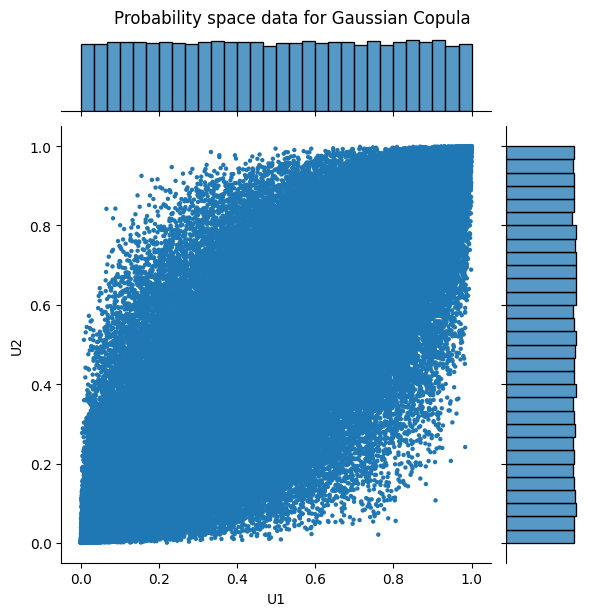

In [6]:
GC = GaussianCopula()
CopulaPlot = plotCopulaData()

U = GC.sampleCopula(n = 100000, correlation=0.8)
CopulaPlot.plotProbabilitySpaceData(U, GC.Name)


### Fit copula to data

Mean: [ 0.00272301 -0.00429486]
Std: [1.00117074 1.00271322]


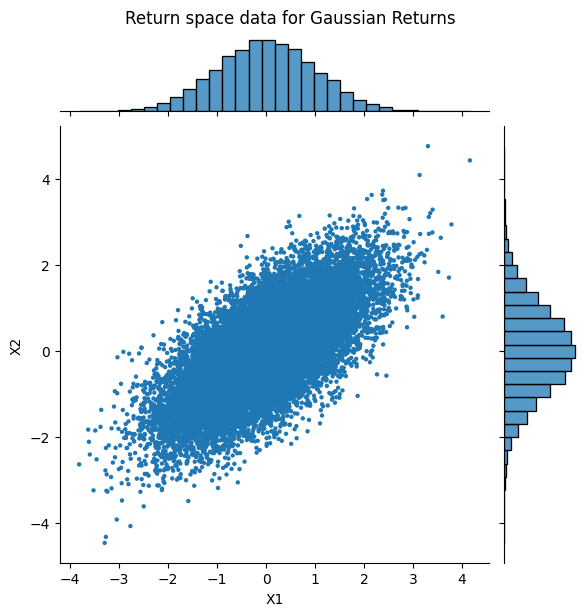

Fitting Gaussian Copula model...
Estimated correlation coefficient:0.6924


array([[1.        , 0.69242211],
       [0.69242211, 1.        ]])

In [7]:
## Generate data
corrMat = np.array([[1, 0.7], [0.7, 1]])
A = np.linalg.cholesky(corrMat)
#np.random.seed(0)
Z = np.random.standard_normal((20000, 2))
X = (A @ Z.T).T # X is dataset that

## Check the data
print('Mean:', np.mean(X, axis=0))
print('Std:',np.std(X, axis=0))
CopulaPlot.plotReturnSpaceData(X, 'Gaussian Returns')

## Fit the model
GC.fitModel(X, 'pearson')
GC.corr


### Generate data from fitted copula


True


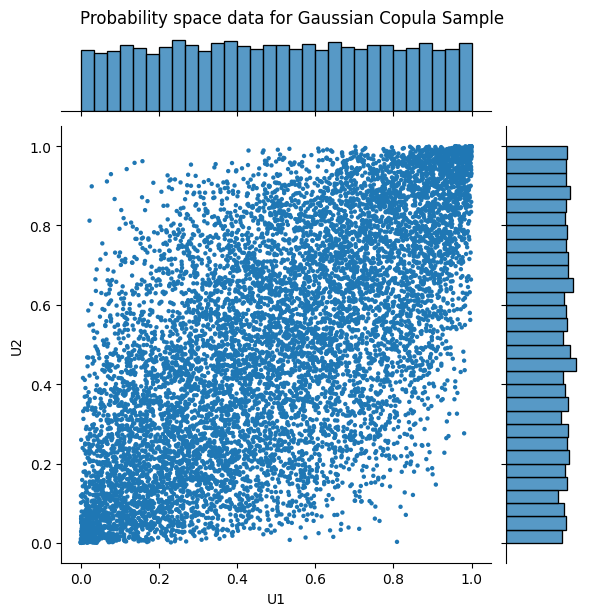

In [8]:
print(GC.IsFitted)
U_sample = GC.sampleCopula(n = 10000)
CopulaPlot.plotProbabilitySpaceData(U_sample, 'Gaussian Copula Sample')


### Evaluate and plot the PDF and CDF respectively

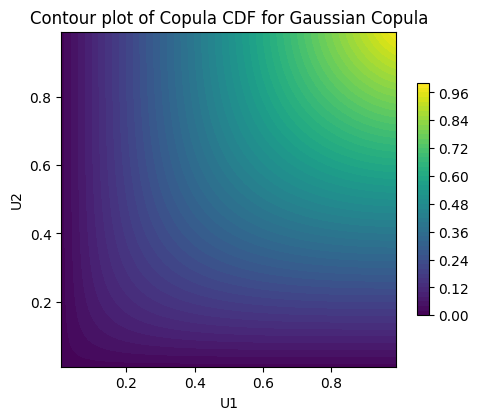

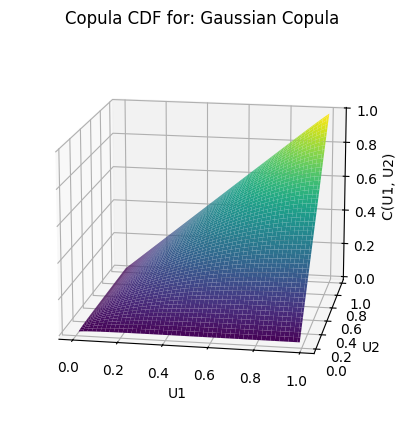

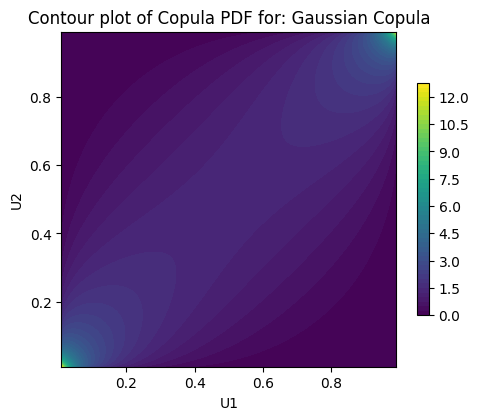

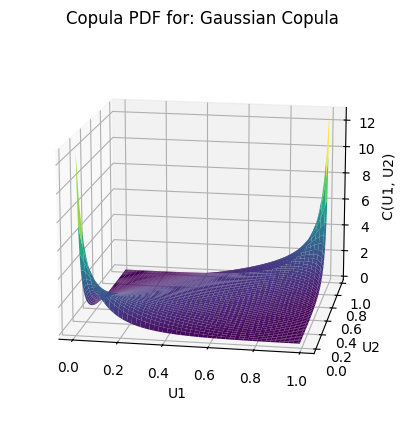

In [9]:
### CDF
CopulaPlot.plotCopulaContour(GC, 'Gaussian Copula')
CopulaPlot.plotCopulaSurface(GC, 'Gaussian Copula')

### PDF
CopulaPlot.plotCopulaPDFContour(GC, 'Gaussian Copula')
CopulaPlot.plotCopulaPDFSurface(GC, 'Gaussian Copula')



## Students Copula

In [20]:
class StudentsCopula():
    def __init__(self):
        self.Name = 'Students Copula'
        self.corr = None
        self.degreeFreedom = None
        self.data = None
        self.transformedData = None
        self.IsFitted = False
        pass

    def fitModel(self, data, correlationMeasure='pearson'):
        # Function to fit copula model     
        print('Fitting Students Copula model...')  
        self.corr = np.corrcoef(data,rowvar=False)
        
        self.data = data
        self.transformedData = norm.cdf(data) ## transform data to uniform marginals from normal marginals
        self.degreeFreedom = self._optimizeDegreesFreedom(self.transformedData)[0] ## gives the optimal degrees of freedom
        self.IsFitted = True
        print('Estimated DF: ', self.degreeFreedom, ' Estimated correlation coefficient: ', self.corr[0,1])
        pass

    def _optimizeDegreesFreedom(self, transformedData):
        # Function to optimize the log likelihood of the copula
        print('Optimizing degrees of freedom...')
        epsilon = 1e-10
        bounds = [(1 , None)] # degrees of freedom must be positive

        x0 = [2] ## initial guess
        objectiveFixData = partial(self._logLikelihood, transformedData = transformedData)
        result = minimize(objectiveFixData, x0, method='L-BFGS-B', bounds=bounds,  )
        if result.x == epsilon:
            print('Optimization failed, boundary value encountered')
        return result.x

    def _logLikelihood(self,  df, transformedData):
        likelihoodvals = self._studentsCopulaPDF(transformedData=transformedData, df = df)
        loglikelihood = np.sum(np.log(likelihoodvals))
        return -loglikelihood    

    def _studentsCopulaPDF(self, transformedData, df):
        mean = np.zeros(2)  
        marginal1 = t.ppf(transformedData[:, 0], df)
        marginal2 = t.ppf(transformedData[:, 1], df)
        marginalLikelihood1 = t.pdf(marginal1, df)
        marginalLikelihood2 = t.pdf(marginal2, df)
        marginals = np.column_stack((marginal1, marginal2))
        dist = multivariate_t(loc=mean, shape=self.corr, df=df)
        pdf_values = dist.pdf(marginals) / (marginalLikelihood1  * marginalLikelihood2)   
        return pdf_values  

    def evalPDF(self, u1,u2):
        # Function to evaluate PDF of copula
        if self.IsFitted == False:
            raise ValueError('Model not fitted')
        else:
            mean = np.zeros(2)  
            marginal1 = t.ppf(u1, self.degreeFreedom)
            marginal2 = t.ppf(u2, self.degreeFreedom)
            marginalLikelihood1 = t.pdf(marginal1, self.degreeFreedom)
            marginalLikelihood2 = t.pdf(marginal2, self.degreeFreedom)
            marginals = np.column_stack((marginal1, marginal2))
            dist = multivariate_t(loc=mean, shape=self.corr, df=self.degreeFreedom)
            CopulaFunction = dist.pdf(marginals) / (marginalLikelihood1  * marginalLikelihood2)   
            return CopulaFunction

    def evalCDF(self, u1,u2):
        # Function to evaluate CDF of copula
        if self.IsFitted == False:
            raise ValueError('Model not fitted')
        else:
            mean = np.zeros(2)  
            marginal1 = t.ppf(u1, self.degreeFreedom)
            marginal2 = t.ppf(u2, self.degreeFreedom)
            dist = multivariate_t(loc=mean, shape=self.corr, df=self.degreeFreedom)
            CopulaFunction = dist.cdf([marginal1, marginal2])
            return CopulaFunction
            
    def sampleCopula(self, n, correlation = 0.0, df = 5):
        # Function to sample data from copula also possible to sample from copula with arbitrary correlation and degrees of freedom
        mean = np.zeros(2)
        if self.IsFitted == True:
            sample = multivariate_t.rvs(mean, self.corr, df, size=n)
            transformedSample = t.cdf(sample, self.degreeFreedom)
        else:
            # Availability to generate data with different correlation and degrees of freedom
            corr =[[1, correlation], [correlation, 1]]
            sample = multivariate_t.rvs(mean, corr, df, size=n)
            transformedSample = t.cdf(sample, df)
        return transformedSample
    

### Generate data

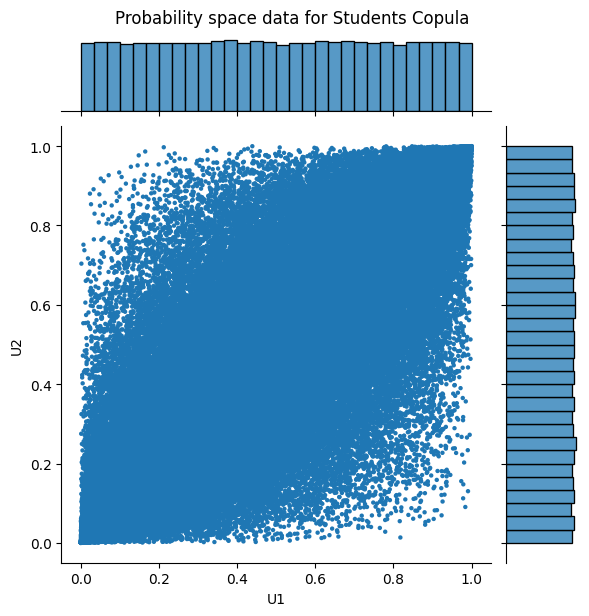

In [11]:
SC = StudentsCopula()
CopulaPlot = plotCopulaData()

U = SC.sampleCopula(n = 100000, correlation = 0.8, df = 10)
CopulaPlot.plotProbabilitySpaceData(U, SC.Name)


### Fit copula to data

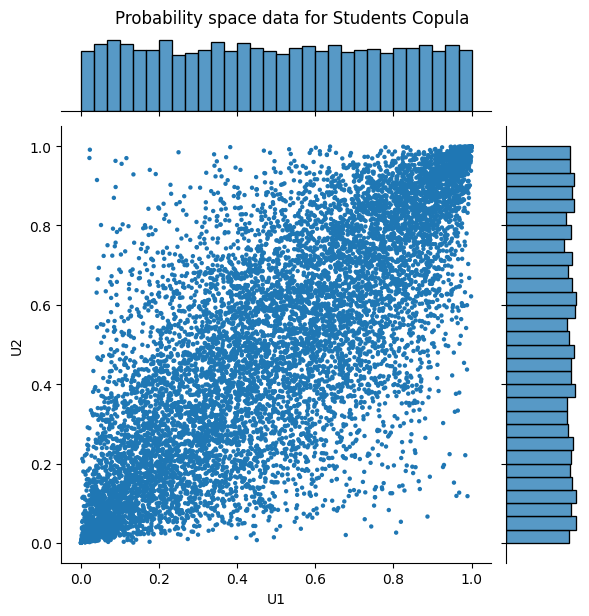

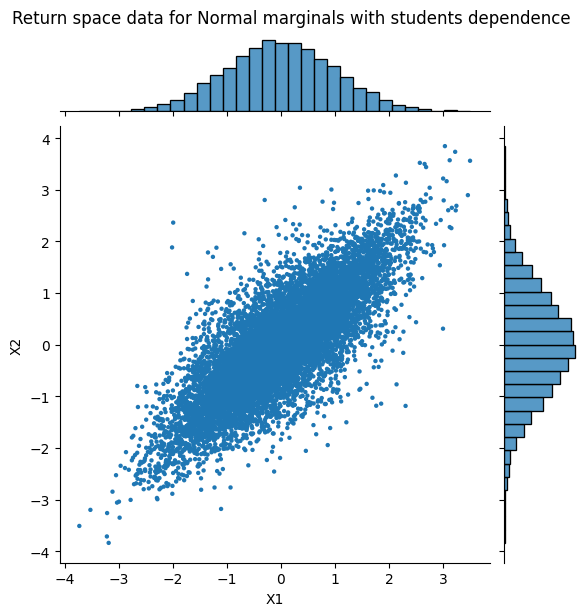

Fitting Students Copula model...
Optimizing degrees of freedom...
Estimated DF:  5.488859707846377  Estimated correlation coefficient:  0.7932209572158149


In [12]:
## Sample and plot data from normal with t dependence
U = SC.sampleCopula(n = 10000, correlation = 0.8, df = 5)
X = norm.ppf(U)
CopulaPlot.plotProbabilitySpaceData(U, SC.Name)
CopulaPlot.plotReturnSpaceData(X, 'Normal marginals with students dependence')


#### Generate data for fitting From pure t distribution
# n = 100000
# df = 5
# mean = np.zeros(2)
# corr = [[1,0.8],[0.8,1]]
# X = multivariate_t.rvs(mean, corr, df, size=n)

# CopulaPlot.plotReturnSpaceData(X, 'Students Returns')
# CopulaPlot.plotReturnSpaceData(X, 'Normal marginals with students dependence')


## Fit the model
SC.fitModel(X, 'pearson')


### Generate data from fitted copula

True


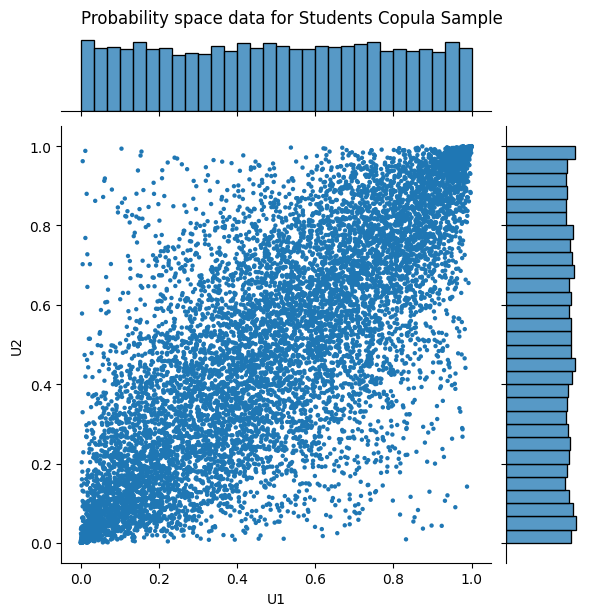

In [13]:
print(SC.IsFitted)
U_sample = SC.sampleCopula(n = 10000)
CopulaPlot.plotProbabilitySpaceData(U_sample, 'Students Copula Sample')


### Evaluate and plot the PDF and CDF respectively

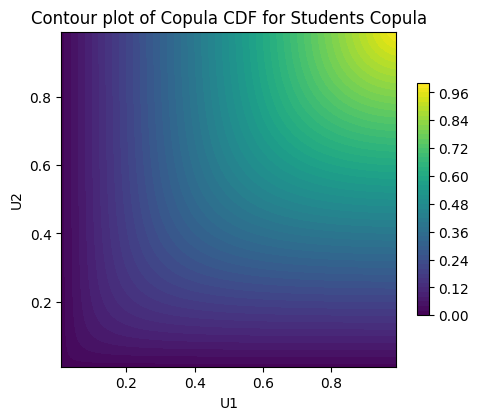

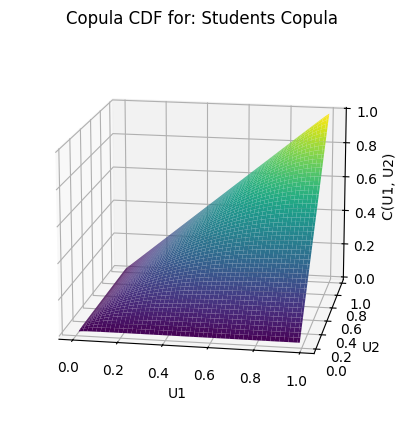

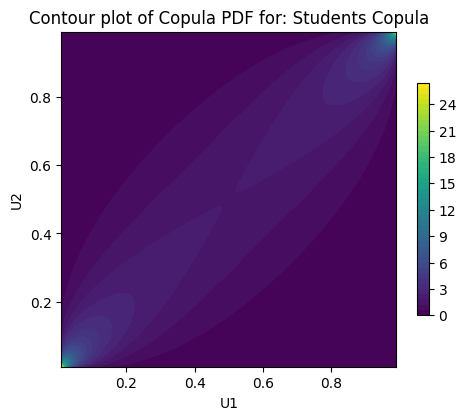

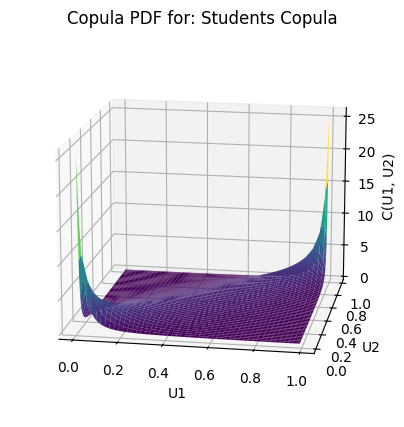

In [14]:
### CDF
CopulaPlot.plotCopulaContour(SC, 'Students Copula')
CopulaPlot.plotCopulaSurface(SC, 'Students Copula')

### PDF
CopulaPlot.plotCopulaPDFContour(SC, 'Students Copula')
CopulaPlot.plotCopulaPDFSurface(SC, 'Students Copula')


## Clayton copula

In [21]:
class ClaytonCopula():
    def __init__(self):
        self.Name = 'Clayton Copula'
        self.theta = None
        self.data = None
        self.transformedData = None
        self.IsFitted = False
        pass

    def fitModel(self, data, initialGuess = 0.1):
        # Function to fit copula model
        print('Fitting Clayton Copula model...')   
        self.data = data
        self.transformedData = norm.cdf(data) ## transform data to uniform marginals from normal marginals

        resultObject = self._optimizeTheta(self.transformedData, initialGuess)
        print('Optimization result: ', resultObject.success)
        iter = 0
        while resultObject.success == False  or iter < 50:
            print('Optimization failed, trying again...')
            print(f'Message: {resultObject.message}')
            initialGuess = np.random.uniform(0.01, 1.0)
            resultObject = self._optimizeTheta(self.transformedData, initialGuess)
            iter += 1

        self.theta = resultObject.x[0] ## gives the optimal theta
        self.IsFitted = True
        epsilon = 1e-10
        if self.theta == epsilon:
            print('Optimization failed, boundary value encountered')
            print('Optimization can be unstable for small values of theta. Please try again with a smaller initial guess')
            self.IsFitted = False
            self.theta = None
        else:
            print('Estimated theta: ', self.theta)
        pass

    def _optimizeTheta(self, transformedData, initialGuess):
        # Function to optimize the log likelihood of the copula
        print('Optimizing theta...')
        epsilon = 1e-10
        bounds = [(0 + epsilon, None)] # theta 
        x0 = [initialGuess] ## Seems to be good to start small rather than large
        objectiveFixData = partial(self._logLikelihood, transformedData = transformedData)
        result = minimize(objectiveFixData, x0, method='L-BFGS-B', bounds=bounds,  )
        return result  #.x

    def _logLikelihood(self, theta, transformedData):
        likelihoodvals = self._claytonCopulaPDF(transformedData, theta)
        loglikelihood = np.sum(np.log(likelihoodvals))
        return -loglikelihood
    
    def _claytonCopulaPDF(self, transformedData, theta):
        u1,u2 = transformedData[:,0], transformedData[:,1]
        pdf_values = (u1**(-theta) + u2**(-theta) - 1)**(-2 - 1/theta) * u1**(-theta - 1) * u2**(-theta - 1)*(theta + 1)
        return pdf_values

    def evalPDF(self, u1,u2, theta = 1):
        # Function to evaluate PDF of copula
        if self.IsFitted:
            theta = self.theta
        pdf_values = (u1**(-theta) + u2**(-theta) - 1)**(-2 - 1/theta) * u1**(-theta - 1) * u2**(-theta - 1)*(theta + 1)
        return pdf_values

    def evalCDF(self, u1,u2, theta = 1):
        # Function to evaluate CDF of copula
        if self.IsFitted:
            theta = self.theta
        CopulaFunction = (u1**(-theta) + u2**(-theta) - 1)**(-1/theta)

        # else:
        #     CopulaFunction = (u1**(-self.theta) + u2**(-self.theta) - 1)**(-1/self.theta)
        return CopulaFunction

    def sampleCopula(self, n, theta = 1):
        if self.IsFitted:
            theta = self.theta
        # u1 = np.random.uniform(size=n)
        # u2 = np.random.uniform(size=n)
        u = np.random.uniform(0, 1, (n, 2))
        U1_star = u[:,0]
        S2 = U1_star ** -theta - 1
        U2_star = ((1 + S2) * u[:,1] ** (-theta / (1 + theta)) - S2) ** (-1 / theta)
        # merge the two samples
        U = np.column_stack((U1_star, U2_star))
        return U


### Generate data from copula

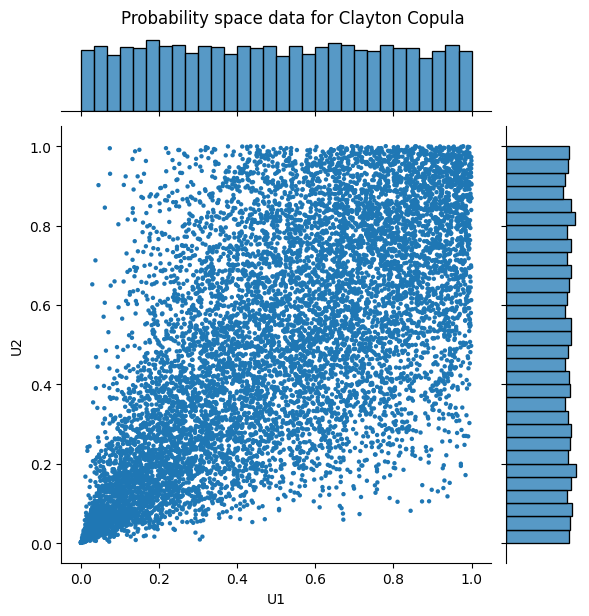

In [16]:
CC = ClaytonCopula()
CopulaPlot = plotCopulaData()

U = CC.sampleCopula(n = 10000, theta = 2)
CopulaPlot.plotProbabilitySpaceData(U, CC.Name)

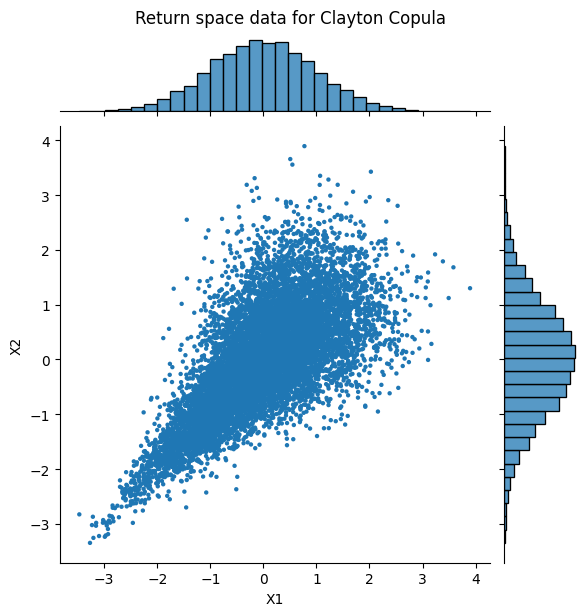

In [17]:
X = norm.ppf(U)
CopulaPlot.plotReturnSpaceData(X, 'Clayton Copula')

In [18]:

# def evalCDF( u1,u2, theta = 1):
#     # Function to evaluate CDF of copula
#     # if self.IsFitted:
#     #     theta = self.theta
#     CopulaFunction = (u1**(-theta) + u2**(-theta) - 1)**(-1/theta)

#     # else:
#     #     CopulaFunction = (u1**(-self.theta) + u2**(-self.theta) - 1)**(-1/self.theta)
#     return CopulaFunction
        
# def sampleCopula( n, theta = 1):
#     # Function to sample data from copula 
#     sampledData = np.zeros((n, 2))

#     # if self.IsFitted == True:
#     #     theta = self.theta
#     # Generate nx2 uniform random numbers
#     U = np.random.uniform(0, 1, (n, 2))
#     # Fix first variable 
#     sampledData[:,0] = U[:,0]
#     # Find maximum value of the copula function when first variable is fixed
#     #m = evalCDF(u1 =  U[:,0], u2 = np.ones(n), theta = theta)
#     # print('m:', m)
#     # print('U:', U)
#     # print(m[:10])
#     # print(U[:10,0])

#     # solve for the second variable
#     sampledData[:,1] = ((U[:,0]*U[:,1])**(-theta) - U[:,0]**(-theta) + 1  )**(-1/theta)
#     return sampledData

# samp = sampleCopula(1000000, 0.8)
# print(samp)
# print(evalCDF(samp[0,0], samp[0,1], 0.8))
# CopulaPlot.plotProbabilitySpaceData(samp, 'Clayton Copula')

In [19]:
# u  = np.linspace(0.01, 0.99, 100)
# u2 = np.ones(100)*0.5
# copulaval = evalCDF(u, u2, 0.8)
# plt.plot(u, copulaval)

In [20]:
# u1 = 0.49515328
# print('u1: ', u1)
# a = u1* 0.45743539
# print('m: ',a)
# alpha = 0.8
# u2 = ((a**(-alpha) - u1**(-alpha) + 1)**(-1/alpha))
# print('u2', u2)
# print('CDF value:', evalCDF(u1, u2, 0.8))

### Fit copula to data

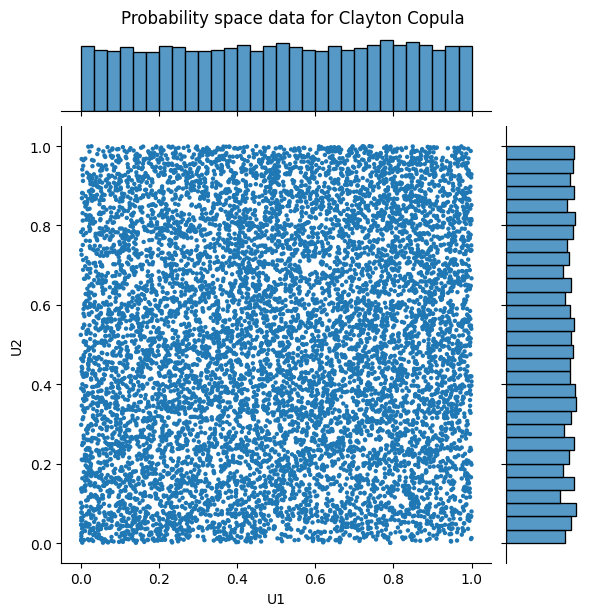

Fitting Clayton Copula model...
Optimizing theta...
Optimization result:  True
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimizing theta...
Optimization failed, trying again...
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FA

In [21]:
## Generate data to for fitting
CC = ClaytonCopula()
CopulaPlot = plotCopulaData()
#np.random.seed(0)
U = CC.sampleCopula(n = 10000, theta = 0.1)
CopulaPlot.plotProbabilitySpaceData(U, CC.Name)
X = norm.ppf(U)

## Fit model
CC.fitModel(X)
print('Theta:', CC.theta)
print('Is fitted? ', CC.IsFitted)

### Generate data from fitted copula

0.09565826545644747


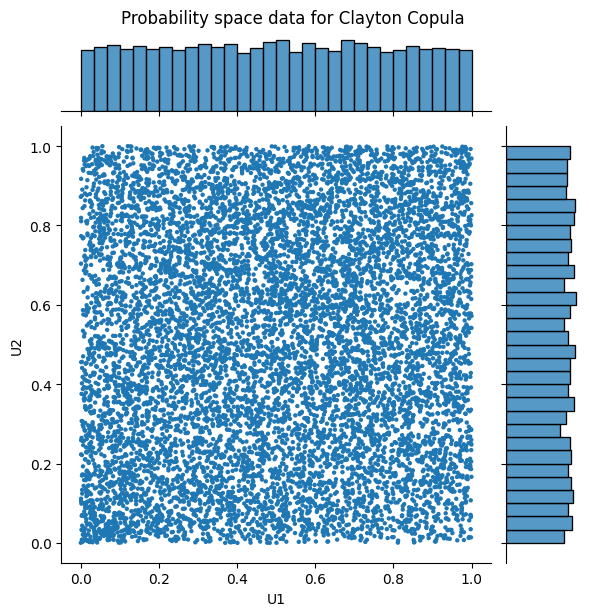

In [22]:
U = CC.sampleCopula(n = 10000)
print(CC.theta)
CopulaPlot.plotProbabilitySpaceData(U, CC.Name)

### Evaluate the PDF and CDF respectively

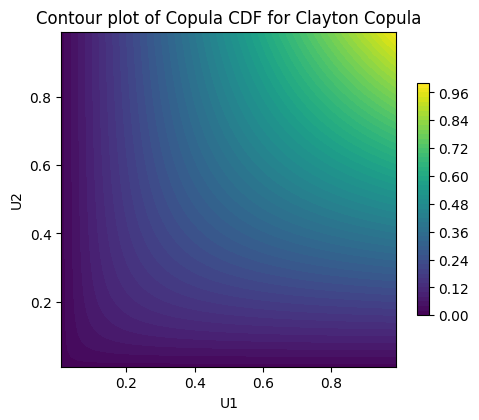

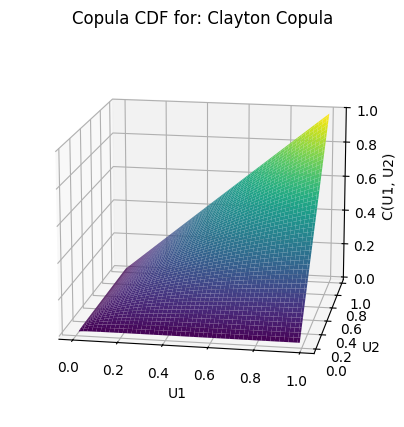

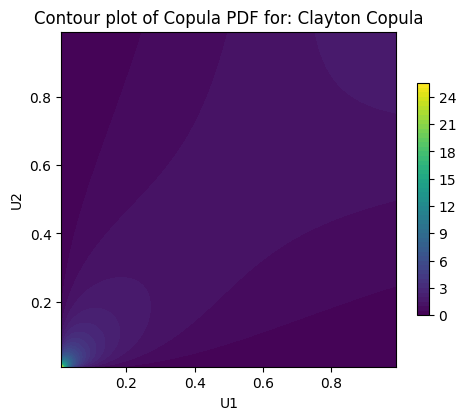

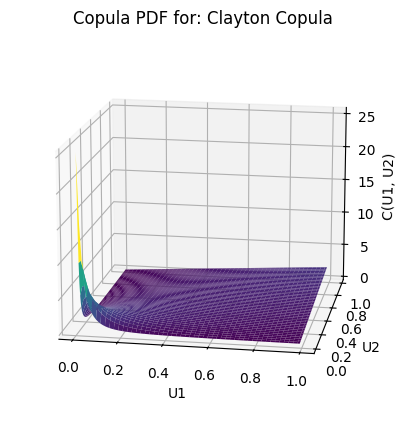

In [23]:
CC.theta = 1
CC.IsFitted = True
### CDF
CopulaPlot.plotCopulaContour(CC, 'Clayton Copula')
CopulaPlot.plotCopulaSurface(CC, 'Clayton Copula')

### PDF
CopulaPlot.plotCopulaPDFContour(CC, 'Clayton Copula')
CopulaPlot.plotCopulaPDFSurface(CC, 'Clayton Copula')

In [24]:
# CC.theta = 1
# CC.IsFitted = True
# ### CDF
# CopulaPlot.plotCopulaContour(CC, 'Clayton Copula')
# CopulaPlot.plotCopulaSurface(CC, 'Clayton Copula')

# ### PDF
# CopulaPlot.plotCopulaPDFContour(CC, 'Clayton Copula')
# CopulaPlot.plotCopulaPDFSurface(CC, 'Clayton Copula')

# Stock trajectory generator

In [22]:
class stockPriceGenerator():
    def __init__(self, marginalDistribution1 = norm, marginalDistribution2 = norm):
        self.M1 = marginalDistribution1
        self.M2 = marginalDistribution2
        # self.stockPrices = None
        # self.stockPriceDF = None
        pass

    def GenerateStockTrajectories(self,copulaRandomnumbers):
        Z = self._generateRandomShocks(copulaRandomNumbers=copulaRandomnumbers) ## generate random shocks
        S = self._eulerMaruyama(s_0 = np.array([100, 100]), Z = Z, mu = np.array([0.03, 0.03]), sigma = np.array([0.2, 0.3]), dt = 1/252) ## simulate stock prices
        return S

    def StockTrajectoriesAsDF(self, S, startDate = '2010-01-01'):
        df = pd.DataFrame(S, columns=['Stock1', 'Stock2'])
        df = self._attachDates(df, startDate=startDate) ## create stock price dataframe
        return df

    def _generateRandomShocks(self, copulaRandomNumbers, marginalDistribution1 = norm, marginalDistribution2=norm):
        # Function to generate random shocks
        Z = np.zeros(copulaRandomNumbers.shape)
        Z[:,0] = marginalDistribution1.ppf(copulaRandomNumbers[:,0])
        Z[:,1] = marginalDistribution2.ppf(copulaRandomNumbers[:,1])
        return Z

    def _eulerMaruyama(self, s_0, Z, mu, sigma, dt):
        # Function to simulate stock prices using Euler Maruyama
        stocks = s_0.shape[0]
        timeSteps = Z.shape[0]
        S = s_0 * np.ones((timeSteps+1, stocks))
        for t in range(1, timeSteps+1):
            S[t, :] =  (S[t-1, :] + S[t-1, :]* mu * dt + S[t-1, :]*sigma * np.sqrt(dt) * Z[t-1, :])
        return S
    
    def _attachDates(self, stockPriceDF, startDate = '2010-01-01'):
        # Function to create stock price DataFrame
        start_date = pd.Timestamp(startDate)
        dates = []
        n = len(stockPriceDF)
        try:
            # Repeat until you get enough dates
            while len(dates) < n:
                # Add 5 weekdays
                weekdays = pd.date_range(start=start_date, periods=5, freq='B')
                dates.extend(weekdays)
                # Add 2 weekend days
                weekends = pd.date_range(start=weekdays[-1] + pd.Timedelta(days=1), periods=2, freq='D')
                dates.extend(weekends)
                # Move start_date forward
                start_date = weekends[-1] + pd.Timedelta(days=1)

            # Trim to match your data length
            dates = dates[:n]

            # Create the dataframe
            #stockPriceDF = pd.DataFrame(S, columns=['Stock1', 'Stock2'])

            ## Append dates to the dataframe
            stockPriceDF['Time'] = dates
            return stockPriceDF

        except (OverflowError, pd.errors.OutOfBoundsDatetime) as e:
            print(f"Date range exceeded pandas limits: {e}")
            return None

        # # Repeat until you get enough dates
        # while len(dates) < len(S):
        #     # Add 5 weekdays
        #     weekdays = pd.date_range(start=start_date, periods=5, freq='B')
        #     dates.extend(weekdays)
        #     # Add 2 weekend days
        #     weekends = pd.date_range(start=weekdays[-1] + pd.Timedelta(days=1), periods=2, freq='D')
        #     dates.extend(weekends)
        #     # Move start_date forward
        #     start_date = weekends[-1] + pd.Timedelta(days=1)

        # # Trim to match your data length
        # dates = dates[:len(S)]

        # # Create the dataframe
        # self.stockPriceDF = pd.DataFrame(S, columns=['Stock1', 'Stock2'])
        # self.stockPriceDF['Time'] = dates
        # return self.stockPriceDF

    def SplitTimeseriesArray(self, S, proportion = 0.6):
        if proportion > 1 or proportion < 0:
            raise ValueError('Proportion must be between 0 and 1')
        n = S.shape[0] 
        splitIndex = int(n * proportion)
        S_fit = S[:splitIndex, :]
        S_test = S[splitIndex:, :]
        return S_fit, S_test

    def SplitTimeseriesDF(self, DF, proportion = 0.6):
        if proportion > 1 or proportion < 0:
            raise ValueError('Proportion must be between 0 and 1')
        n = DF.shape[0]
        splitIndex = int(n * proportion)
        DF_fit = DF.iloc[:splitIndex, :]
        DF_test = DF.iloc[splitIndex-1:, :]
        return DF_fit, DF_test

    def CalculateLogReturns(self, S):
        # Function to calculate log returns
        logReturns = np.log(S[1:,:] / S[:-1,:])
        return logReturns

    def CalculateSimpleReturns(self, S):
        # Function to calculate simple returns
        simpleReturns = ((S[1:,:] - S[:-1,:])/ S[:-1,:])
        return simpleReturns



### Splitting test

<Figure size 800x400 with 0 Axes>

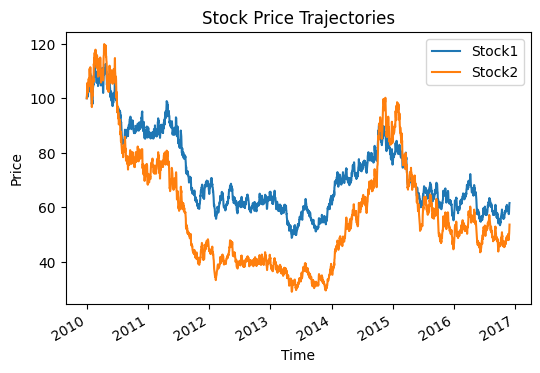

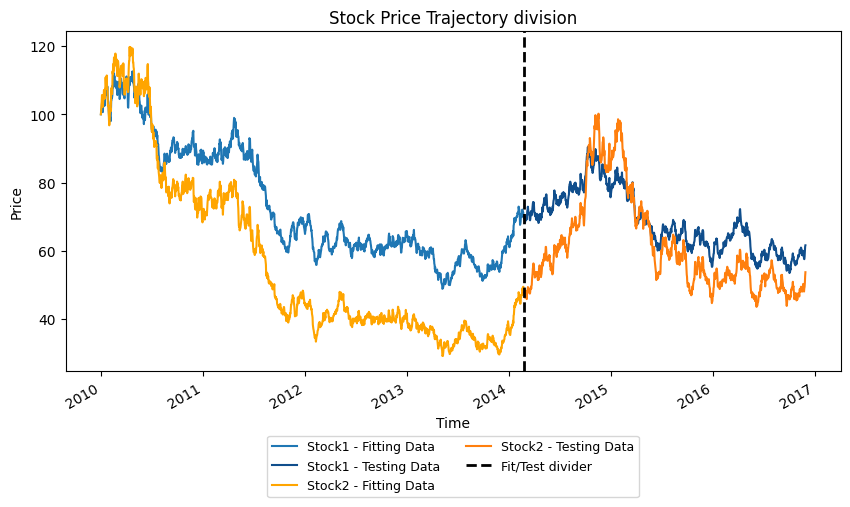

In [26]:
GC = GaussianCopula()
CopulaPlot = plotCopulaData()
StockGenerator = stockPriceGenerator()
U = GC.sampleCopula(2520, 0.8)
#CopulaPlot.plotProbabilitySpaceData(U, GC.Name)
S = StockGenerator.GenerateStockTrajectories(U)
df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
CopulaPlot.plotStockTrajectory(df, 'Stock Price Trajectories')

FittingDF, TestingDF = StockGenerator.SplitTimeseriesDF(df, proportion = 0.6)
CopulaPlot.plotStockPriceSections(FittingDF, TestingDF)


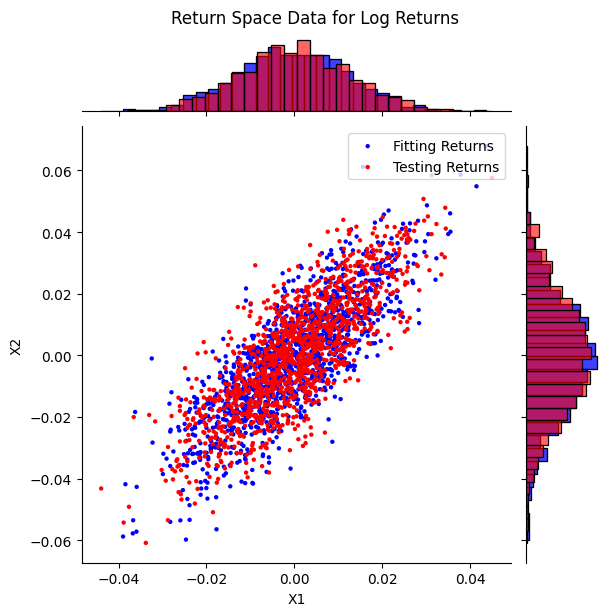

In [27]:
Fitting, Testing = StockGenerator.SplitTimeseriesArray(S, proportion = 0.5)
fittingReturns = StockGenerator.CalculateLogReturns(Fitting)
testingReturns = StockGenerator.CalculateLogReturns(Testing)

CopulaPlot.plotFittingTestComparison(fittingReturns, testingReturns, title = 'Log Returns')


### Gaussian copula

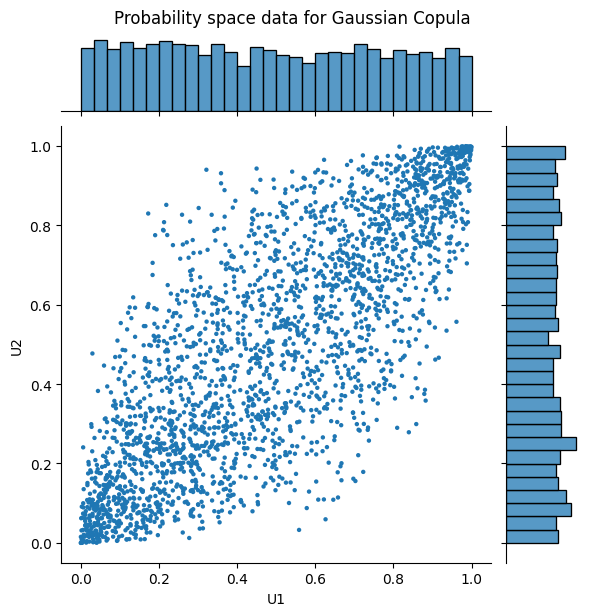

<Figure size 800x400 with 0 Axes>

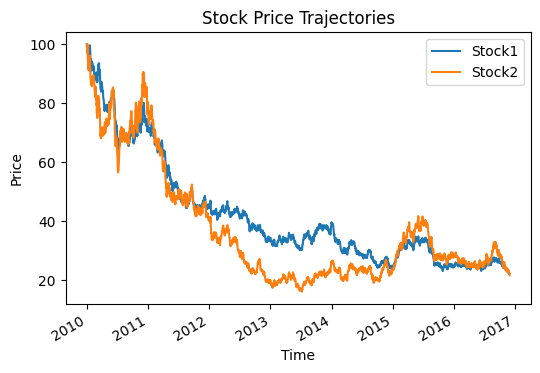

In [28]:
GC = GaussianCopula()
CopulaPlot = plotCopulaData()
StockGenerator = stockPriceGenerator()
U = GC.sampleCopula(2520, 0.8)
CopulaPlot.plotProbabilitySpaceData(U, GC.Name)
S = StockGenerator.GenerateStockTrajectories(U)
df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
CopulaPlot.plotStockTrajectory(df, 'Stock Price Trajectories')



Sampled standard deviations: [0.01265575 0.01921653]
Theoretical standard deviations: [0.01259882 0.01889822]


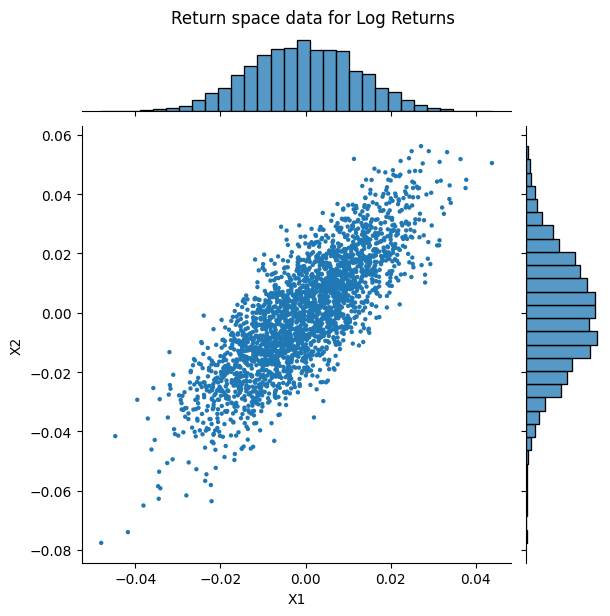

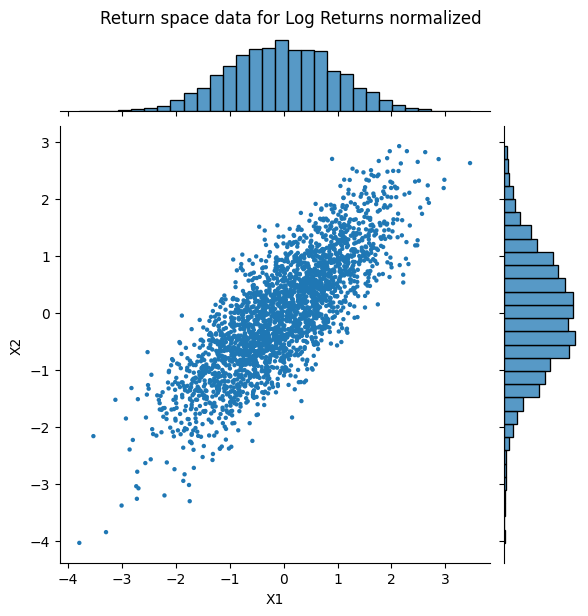

In [29]:
logRet = StockGenerator.CalculateLogReturns(S)
normalizedLogRet = logRet / np.std(logRet, axis=0)
print('Sampled standard deviations:', np.std(logRet, axis=0))
print('Theoretical standard deviations:', np.array([0.2, 0.3]) * np.sqrt(1/252))
CopulaPlot.plotReturnSpaceData(logRet, 'Log Returns')
CopulaPlot.plotReturnSpaceData(normalizedLogRet , 'Log Returns normalized')

### Students copula

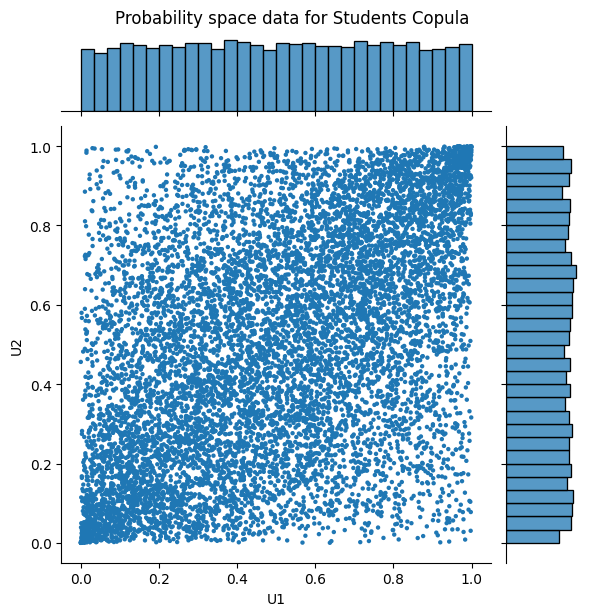

<Figure size 800x400 with 0 Axes>

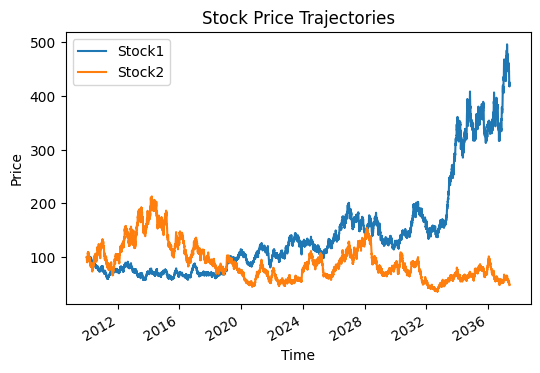

In [30]:
SC = StudentsCopula()
CopulaPlot = plotCopulaData()
StockGenerator = stockPriceGenerator()
U = SC.sampleCopula(10000, correlation=0.5,df= 5 )
CopulaPlot.plotProbabilitySpaceData(U, SC.Name)
S = StockGenerator.GenerateStockTrajectories(U)
df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
CopulaPlot.plotStockTrajectory(df, 'Stock Price Trajectories')


Sampled standard deviations: [0.01237873 0.01854958]
Theoretical standard deviations: [0.01259882 0.01889822]


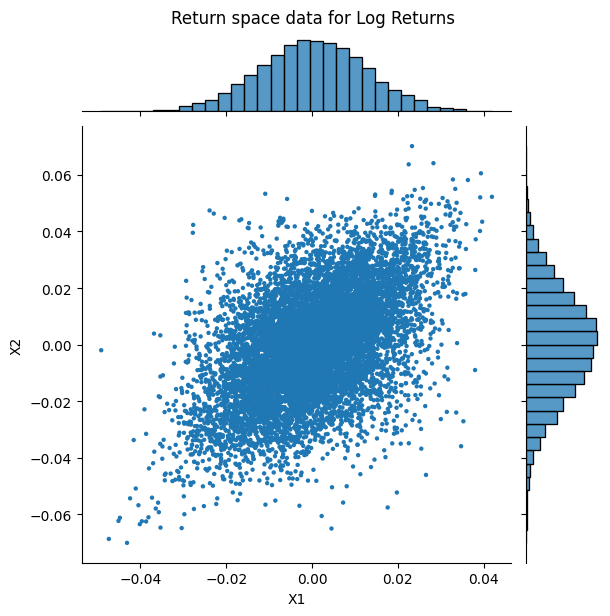

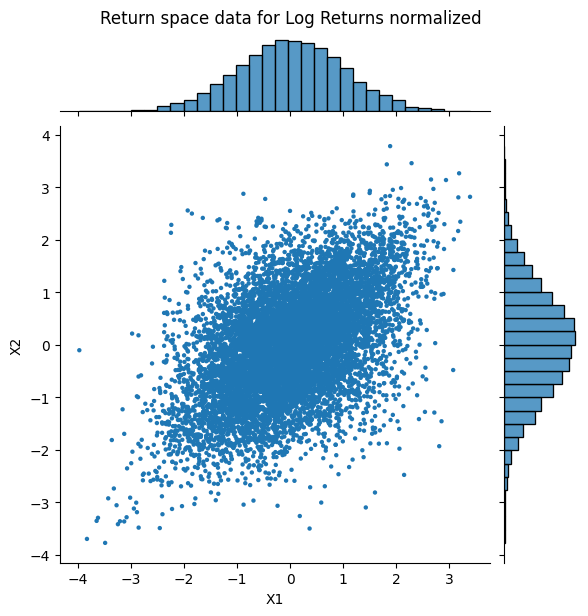

In [31]:
logRet = StockGenerator.CalculateLogReturns(S)
normalizedLogRet = logRet / np.std(logRet, axis=0)
print('Sampled standard deviations:', np.std(logRet, axis=0))
print('Theoretical standard deviations:', np.array([0.2, 0.3]) * np.sqrt(1/252))
CopulaPlot.plotReturnSpaceData(logRet, 'Log Returns')
CopulaPlot.plotReturnSpaceData(normalizedLogRet , 'Log Returns normalized')

### Clayton copula

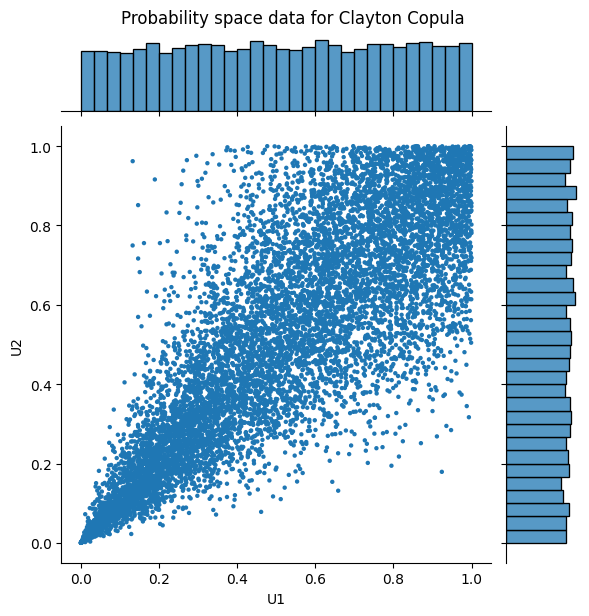

<Figure size 800x400 with 0 Axes>

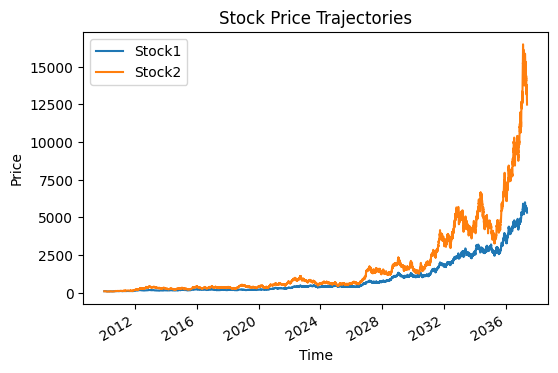

In [32]:
CC = ClaytonCopula()
CopulaPlot = plotCopulaData()
StockGenerator = stockPriceGenerator()
U = CC.sampleCopula(10000, theta = 4)
CopulaPlot.plotProbabilitySpaceData(U, CC.Name)
S = StockGenerator.GenerateStockTrajectories(U)
df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
CopulaPlot.plotStockTrajectory(df, 'Stock Price Trajectories')


Sampled standard deviations: [0.01257113 0.01892308]
Theoretical standard deviations: [0.01259882 0.01889822]


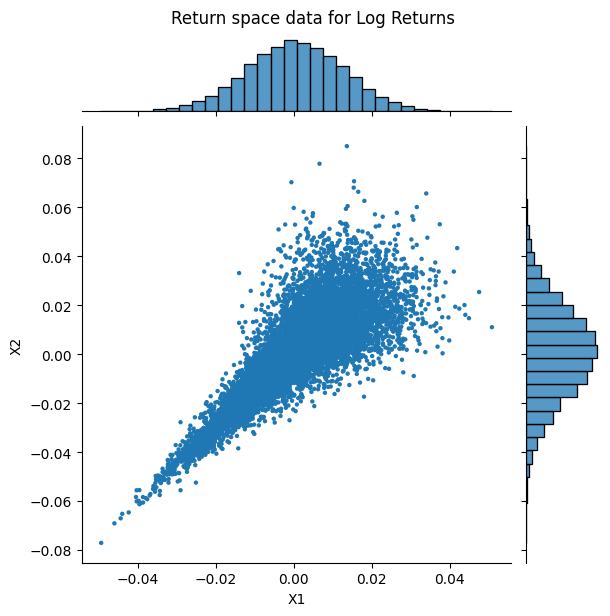

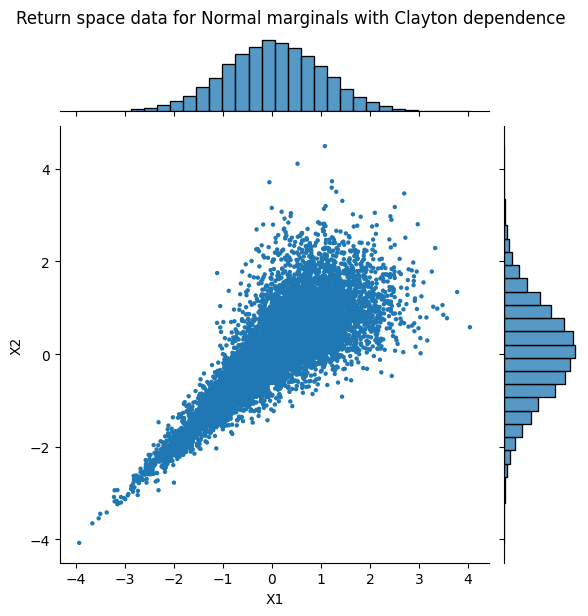

In [33]:
logRet = StockGenerator.CalculateLogReturns(S)
normalizedLogRet = logRet / np.std(logRet, axis=0)
print('Sampled standard deviations:', np.std(logRet, axis=0))
print('Theoretical standard deviations:', np.array([0.2, 0.3]) * np.sqrt(1/252))
CopulaPlot.plotReturnSpaceData(logRet, 'Log Returns')
# CopulaPlot.plotReturnSpaceData(normalizedLogRet , 'Log Returns normalized')
CopulaPlot.plotReturnSpaceData(normalizedLogRet , 'Normal marginals with Clayton dependence')

# Code Runner bilding 

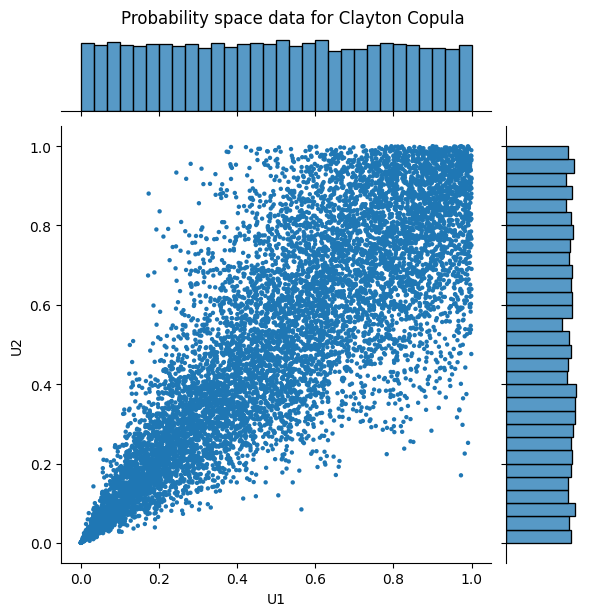

In [34]:
CC = ClaytonCopula()
CopulaPlot = plotCopulaData()
StockGenerator = stockPriceGenerator()
U = CC.sampleCopula(10000, theta = 4)
CopulaPlot.plotProbabilitySpaceData(U, CC.Name)
S = StockGenerator.GenerateStockTrajectories(U)


In [ ]:
# from scipy.stats import gaussian_kde

# def compareDistributions(SampleReturns, TestReturns):
#     X = SampleReturns
#     Y = TestReturns

#     x1_max, x2_max = np.max(SampleReturns, axis = 0)
#     y1_max, y2_max = np.max(TestReturns, axis = 0)
#     x1_min, x2_min = np.min(SampleReturns, axis = 0)
#     y1_min, y2_min = np.min(TestReturns, axis = 0)

#     X1_min = np.min([x1_min,y1_min])
#     X1_max = np.max([x1_max,y1_max])
#     X2_min = np.min([x2_min,y2_min])
#     X2_max = np.max([x2_max,y2_max])
#     num_points = 100
#     x1_Dim_range = np.linspace(X1_min, X1_max, num_points)
#     x2_Dim_range = np.linspace(X2_min, X2_max, num_points)

#     ## create meshgrid
#     X1_grid, X2_grid = np.meshgrid(x1_Dim_range, x2_Dim_range)
#     grid_coords = np.vstack([X1_grid.ravel(), X2_grid.ravel()]).T

#     ## estimate 2D KDEs
#     kde_X = gaussian_kde(X.T)
#     kde_Y = gaussian_kde(Y.T)

#     ## compute density at each grid point
#     Z_X = kde_X(grid_coords.T)
#     Z_Y = kde_Y(grid_coords.T)

#     # Normalize to form probability distributions (sum to 1)
#     Z_X /= Z_X.sum()
#     Z_Y /= Z_Y.sum()

#     ## Reshape Z for plotting
#     Z_X = Z_X.reshape(X1_grid.shape)
#     Z_Y = Z_Y.reshape(X1_grid.shape)

#     ## Plot the estimated density
#     plt.figure(figsize=(6,5))
#     plt.contourf(X1_grid, X2_grid, Z_X, levels=100, cmap='viridis')
#     plt.colorbar(label='Density')
#     plt.scatter(X[:, 0], X[:, 1], s=1, color='white', alpha=0.5, label='Data points')
#     plt.title("Gaussian Kernel Density Estimation Distribution 1")
#     plt.xlabel("X1")
#     plt.ylabel("X2")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     ## Plot the estimated density
#     plt.figure(figsize=(6, 5))
#     plt.contourf(X1_grid, X2_grid, Z_Y, levels=100, cmap='viridis')
#     plt.colorbar(label='Density')
#     plt.scatter(Y[:, 0], Y[:, 1], s=1, color='white', alpha=0.5, label='Data points')
#     plt.title("Gaussian Kernel Density Estimation Distribution 2")
#     plt.xlabel("X1")
#     plt.ylabel("X2")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     ## Calculate the step size for each dimension
#     dX1 = (X1_max - X1_min) / num_points
#     dX2 = (X2_max - X2_min) / num_points

#     ## Create cumulative distribution functions (CDFs)
#     Z_cdf_X = Z_X.cumsum(axis=0).cumsum(axis=1)
#     Z_cdf_Y = Z_Y.cumsum(axis=0).cumsum(axis=1)

#     ## Calculate distance
#     dist =  (np.sum((Z_cdf_X - Z_cdf_Y)**2 *dX1*dX2))**(1/2) 

#     return dist



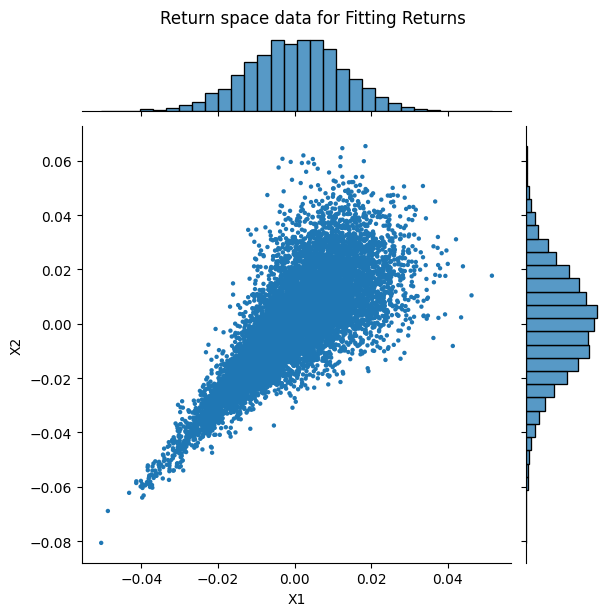

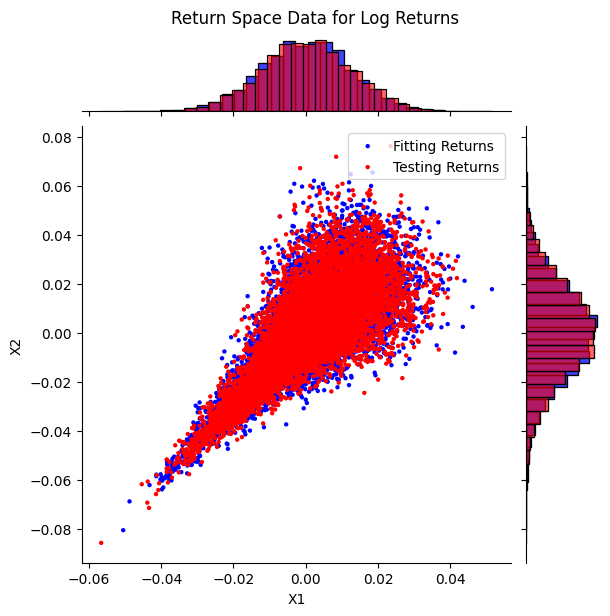

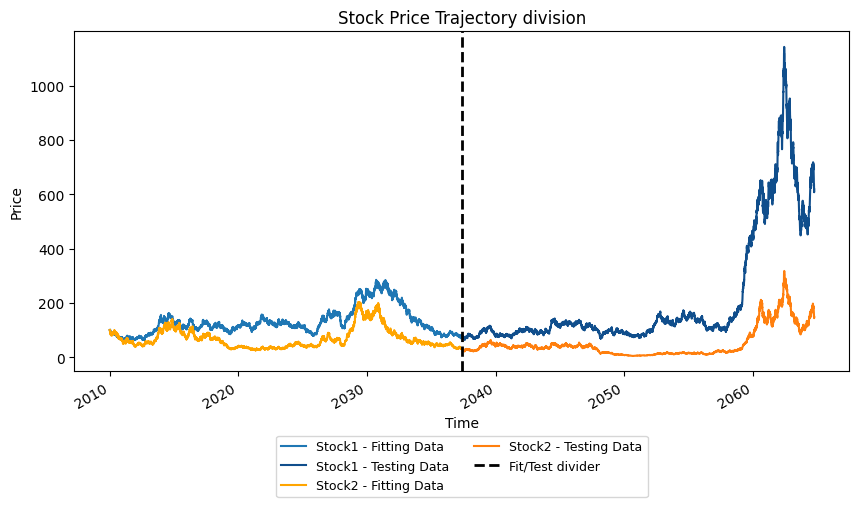

Fitting Gaussian Copula model...
Estimated correlation coefficient:0.7741


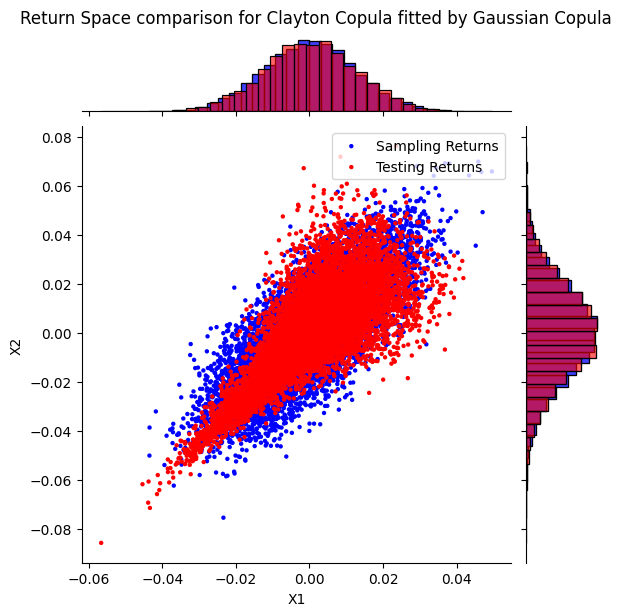

Computing distance...


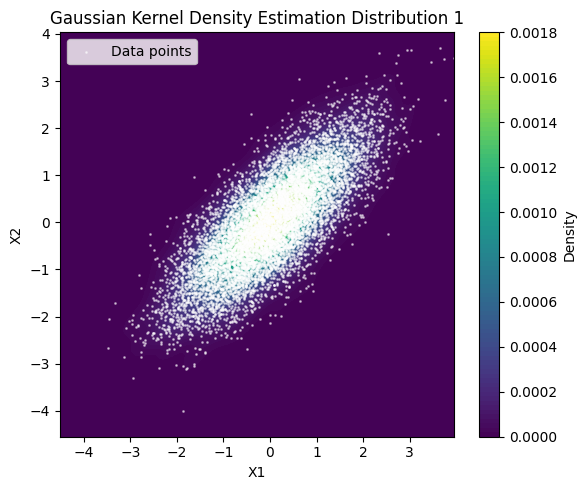

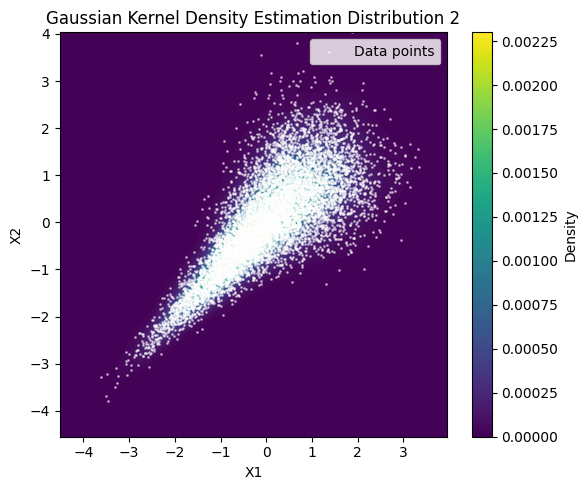

 The distance between the distributions is: 0.04979124989997841


In [59]:
CC = ClaytonCopula()
U = CC.sampleCopula(20000, theta = 3)
StockGenerator = stockPriceGenerator()
S = StockGenerator.GenerateStockTrajectories(U)
df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')

FittingDF, TestingDF = StockGenerator.SplitTimeseriesDF(df, proportion = 0.5)
FittingArray, TestingArray = FittingDF.iloc[:,0:-1].to_numpy(), TestingDF.iloc[:,0:-1].to_numpy()
FittingReturns = StockGenerator.CalculateLogReturns(FittingArray)
FittingNormalizedReturns = FittingReturns / np.std(FittingReturns, axis=0)
TestingReturns = StockGenerator.CalculateLogReturns(TestingArray)
CopulaPlot.plotReturnSpaceData(FittingReturns, 'Fitting Returns')
CopulaPlot.plotFittingTestComparison(FittingReturns, TestingReturns, title = 'Log Returns')
CopulaPlot.plotStockPriceSections(FittingDF, TestingDF)

CCFit = GaussianCopula()
CCFit.fitModel(FittingNormalizedReturns)
SampledReturns = CCFit.sampleCopula(10000)
SampledReturns = norm.ppf(SampledReturns)
ScaledSampledReturns = SampledReturns * np.std(FittingReturns, axis=0) 
CopulaPlot.plotSampleTestComparison(ScaledSampledReturns, TestingReturns, SampledType = CCFit.Name, TestingType = CC.Name)




print('Computing distance...')
print(f' The distance between the distributions is: { compareDistributions(ScaledSampledReturns/np.std(FittingReturns, axis=0) , TestingReturns/np.std(FittingReturns, axis=0) )}')

In [86]:

class PortfolioData():
    def __init__(self, dataDF, Name, proportion = 0.5):
        self.DataGenerator = stockPriceGenerator()
        self.Name = Name
        self.PriceDF = dataDF
        self.FittingDF , self.TestingDF = self.DataGenerator.SplitTimeseriesDF(dataDF, proportion=proportion)
        self.FittingArray, self.TestingArray = self.FittingDF.iloc[:,0:-1].to_numpy(), self.TestingDF.iloc[:,0:-1].to_numpy()
        self.FittingReturns = self.DataGenerator.CalculateLogReturns(self.FittingArray)
        self.TestingReturns = self.DataGenerator.CalculateLogReturns(self.TestingArray)

        self.estimatedStd = np.std(self.FittingReturns, axis=0)
        self.FittingNormalizedReturns = self.FittingReturns / self.estimatedStd
        
        self.FittingSampleDict = {}
        pass

    def fitAndSampleCopulas(self, CopulaList, number = 10000):

        for copula in CopulaList:
            copula.fitModel(self.FittingNormalizedReturns)
            SampledReturns = norm.ppf(copula.sampleCopula(number)) * self.estimatedStd
            self.FittingSampleDict[copula.Name] = SampledReturns
            print('----------------------------------------')
        pass

    def PlotSampledTestComparison(self):
        for copulaName, SampledReturns in self.FittingSampleDict.items():
            CopulaPlot.plotSampleTestComparison(SampledReturns, self.TestingReturns, SampledType = copulaName, TestingType = self.Name)
            #print('Testing returns: ', self.TestingReturns.shape[0], ' Sampled returns: ', SampledReturns.shape[0])
        pass

    def printDistances(self):
        for copulaName, SampledReturns in self.FittingSampleDict.items():
            dist = self._compareDistributions(SampledReturns, self.TestingReturns)
            print(f'Distance for {copulaName} is: {dist}')
        pass

    def _compareDistributions(self, SampleReturns, TestReturns):
        SampleReturns = SampleReturns[~np.isinf(SampleReturns).any(axis=1)]
        X = SampleReturns
        Y = TestReturns

        x1_max, x2_max = np.max(SampleReturns, axis = 0)
        y1_max, y2_max = np.max(TestReturns, axis = 0)
        x1_min, x2_min = np.min(SampleReturns, axis = 0)
        y1_min, y2_min = np.min(TestReturns, axis = 0)

        X1_min = np.min([x1_min,y1_min])
        X1_max = np.max([x1_max,y1_max])
        X2_min = np.min([x2_min,y2_min])
        X2_max = np.max([x2_max,y2_max])
        num_points = 100
        x1_Dim_range = np.linspace(X1_min, X1_max, num_points)
        x2_Dim_range = np.linspace(X2_min, X2_max, num_points)

        ## create meshgrid
        X1_grid, X2_grid = np.meshgrid(x1_Dim_range, x2_Dim_range)
        grid_coords = np.vstack([X1_grid.ravel(), X2_grid.ravel()]).T

        ## estimate 2D KDEs
        kde_Y = gaussian_kde(Y.T)
        kde_X = gaussian_kde(X.T)
        

        ## compute density at each grid point
        Z_X = kde_X(grid_coords.T)
        Z_Y = kde_Y(grid_coords.T)

        # Normalize to form probability distributions (sum to 1)
        Z_X /= Z_X.sum()
        Z_Y /= Z_Y.sum()

        ## Reshape Z for plotting
        Z_X = Z_X.reshape(X1_grid.shape)
        Z_Y = Z_Y.reshape(X1_grid.shape)

        # ## Plot the estimated density
        # plt.figure(figsize=(6,5))
        # plt.contourf(X1_grid, X2_grid, Z_X, levels=100, cmap='viridis')
        # plt.colorbar(label='Density')
        # plt.scatter(X[:, 0], X[:, 1], s=1, color='white', alpha=0.5, label='Data points')
        # plt.title("Gaussian Kernel Density Estimation Distribution 1")
        # plt.xlabel("X1")
        # plt.ylabel("X2")
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

        # ## Plot the estimated density
        # plt.figure(figsize=(6, 5))
        # plt.contourf(X1_grid, X2_grid, Z_Y, levels=100, cmap='viridis')
        # plt.colorbar(label='Density')
        # plt.scatter(Y[:, 0], Y[:, 1], s=1, color='white', alpha=0.5, label='Data points')
        # plt.title("Gaussian Kernel Density Estimation Distribution 2")
        # plt.xlabel("X1")
        # plt.ylabel("X2")
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

        ## Calculate the step size for each dimension
        dX1 = (X1_max - X1_min) / num_points
        dX2 = (X2_max - X2_min) / num_points

        ## Create cumulative distribution functions (CDFs)
        Z_cdf_X = Z_X.cumsum(axis=0).cumsum(axis=1)
        Z_cdf_Y = Z_Y.cumsum(axis=0).cumsum(axis=1)

        ## Calculate distance
        dist =  (np.sum((Z_cdf_X - Z_cdf_Y)**2 *dX1*dX2))**(1/2) 
        return dist


# CC = ClaytonCopula()
# U = CC.sampleCopula(20000, theta= 3)
# StockGenerator = stockPriceGenerator()
# S = StockGenerator.GenerateStockTrajectories(U)
# df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')

# PData = PortfolioData(df, CC.Name , proportion=0.5)


# GCo = GaussianCopula()
# SCo = StudentsCopula()
# CCo = ClaytonCopula()
# PData.fitAndSampleCopulas([CCo, GCo, SCo])
# #print(PData.FittingSampleDict.keys())
# PData.PlotSampledTestComparison()
# PData.printDistances()


In [35]:
# def CreatePortfolios(portfolioDictionary, proportion = 0.5):
#     portfolios = {}
#     for key, value in portfolioDictionary.items():
#         copula = value['Copula']
#         copulaName = copula.Name
#         if copulaName == 'Gaussian Copula':
#             U = copula.sampleCopula(10000, correlation=value['correlation'])
#         elif copulaName == 'Students Copula':
#             U = copula.sampleCopula(10000, correlation=value['correlation'], df=value['df'])
#         elif copulaName == 'Clayton Copula':
#             U = copula.sampleCopula(10000, theta=value['theta'])
        
#         S = StockGenerator.GenerateStockTrajectories(U)
#         df = StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
#         portfolios[key] = PortfolioData(df, key, proportion=proportion)    
#     return portfolios

# StockGenerator = stockPriceGenerator()


# dict = {'Gaussian_0.5': {'Copula': GaussianCopula(), 'correlation': 0.0},
#         'Students_0.5_5': {'Copula': StudentsCopula(), 'correlation': 0.0, 'df': 5},
#         'Clayton_4': {'Copula': ClaytonCopula(), 'theta': 3}}

# np.random.seed(2)

# # dict = {
# #          'Students_0.5_5': {'Copula': StudentsCopula(), 'correlation': 0.0, 'df': 5}}

# Portfolios = CreatePortfolios(dict, proportion=0.5)
# copulaList = [GaussianCopula(), StudentsCopula(), ClaytonCopula()]

# for key, value in Portfolios.items():
#     print(key)
#     value.fitAndSampleCopulas(copulaList)





In [90]:
class CodeRunner():
    def __init__(self, portfolioSpecificationDict, copulaList, n = 10000, proportion = 0.5):
        self.PortfolioSpecifications = portfolioSpecificationDict
        self.CopulaList = copulaList
        self.proportion = proportion
        self.n = n
        self.Portfolios = {}
        self.StockGenerator = stockPriceGenerator()
        pass

    def createPortfolios(self):
        # Function to sample portfolios
        for key, value in self.PortfolioSpecifications.items():
            copula = value['Copula']
            copulaName = copula.Name
            if copulaName == 'Gaussian Copula':
                U = copula.sampleCopula(self.n, correlation=value['correlation'])
            elif copulaName == 'Students Copula':
                U = copula.sampleCopula(self.n, correlation=value['correlation'], df=value['df'])
            elif copulaName == 'Clayton Copula':
                U = copula.sampleCopula(self.n, theta=value['theta'])
            
            S = self.StockGenerator.GenerateStockTrajectories(U)
            df = self.StockGenerator.StockTrajectoriesAsDF(S, startDate='2010-01-01')
            self.Portfolios[key] = PortfolioData(df, key, proportion=self.proportion)    
        pass

    def fitCopulas(self):
        for key, portfolio in self.Portfolios.items():
            print('##############################################')
            print('Portfolio:', key)
            print('##############################################')
            print('----------------------------------------------')
            portfolio.fitAndSampleCopulas(self.CopulaList, number=int(np.floor(self.n/2)))

    def displayResults(self):
        for key, portfolio in self.Portfolios.items():
            print('----------------------------------------------')
            print('Portfolio:', key)
            print('----------------------------------------------')
            distance = portfolio.printDistances()
            portfolio.PlotSampledTestComparison()
            
    def insertRealData(self, filename, portfolioName):
        ## Function to insert real data into the portfolio ddictionary
        loadedData = pd.read_csv(filename, index_col=0)
        data = loadedData.copy()
        data.reset_index(inplace=True)
        data.rename(columns={'Date': 'Time', 'AAPL': 'Stock1', 'AMZN': 'Stock2'}, inplace=True)
        data = data[['Stock1', 'Stock2', 'Time']]
        self.Portfolios[portfolioName] = PortfolioData(data, portfolioName, proportion=self.proportion)




np.random.seed(1)
copulaSpecDict = {'Gaussian_0.5': {'Copula': GaussianCopula(), 'correlation': 0.50},
       #'Students_0.8_5': {'Copula': StudentsCopula(), 'correlation': 0.8, 'df': 5},
       #'Clayton_4': {'Copula': ClaytonCopula(), 'theta': 3}
       }

copulaList = [ GaussianCopula(), ClaytonCopula(), StudentsCopula()] ##  
CopulaPlot = plotCopulaData()

CodeRun = CodeRunner(copulaSpecDict, copulaList, n = 10000, proportion = 0.5)
CodeRun.createPortfolios()
#CodeRun.insertRealData(filename = 'apple_amazon_since_1997.csv', portfolioName = 'Apple_Amazon')
#CodeRun.fitCopulas()
#CodeRun.displayResults()


